# Plot relatives onto PCA

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
from matplotlib import gridspec

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

from python.plot_pca import *  # Import functions needed for the PCA plotting
from ancIBD.ibd_stats.funcs import new_columns, find_relatives, give_sub_df

compute-a-16-104.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.8.12 (default, Sep 13 2021, 17:05:27) 
[GCC 9.2.0]


# 1a) Load PCA and meta annotation

In [2]:
### Load cluster assignments
df_clst = pd.read_csv("./data/cluster_assignments_punic.v54.1j.tsv", sep="\t")
print(f"Loaded Cluster Information for {len(df_clst)} Individuals.\n")

### Load PCA data
min_snp = 20000
path_pca = "./output/pca/v54.1/20221108.punic.v54.1_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v54.1.anno.csv"
savepath="./output/pca/v54.1/20221108.punic.v54.1_HO.construct_WE_NA_PCA.smYES.outitY.evec.anno.tsv"

# v51.1 has some different labels
#path_pca = "./output/pca/v51.1/20220317.punic.v51.1_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
#path_meta = "/n/groups/reich/hringbauer/Data/v51.1.anno.csv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "clst", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "lat", "lon", "study"]]
df = pd.merge(df, df2, on="iid", how="left")

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
df.loc[df["clst"].isnull(), "clst"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # Remove Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")

df.to_csv(savepath, index=False, sep="\t")
print(f"Saved annotated PCA with {len(df)} entries to {savepath}")
#df[df["pop"].str.contains("Lebanon")]

Loaded Cluster Information for 160 Individuals.

Filtering to 2548/2571
Filtered to 2507 Individuals based on Min SNP: 20000
Filtered to 2424 based on duplicates
Filtered to 2423 based on manual removals
Saved annotated PCA with 2423 entries to ./output/pca/v54.1/20221108.punic.v54.1_HO.construct_WE_NA_PCA.smYES.outitY.evec.anno.tsv


# 1b) Load Population DataFrames to plot

In [3]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA"])
df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA.SG"])
df_isp = get_sub_pops(df, pop_list=["Israel_Phoenician"], pop_col = "clst")

df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])
df_sard_ba = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_EBA","Italy_Sardinia_BA_Nuragic"])


df_tun = get_sub_pops(df, pop_list=["Djebba", "Doukanet el Khoutifa", "Hergla"], pop_col="loc")

df_gua = get_sub_pops(df, pop_list=["Guanche"])

df_vil = get_sub_iid(df, ["VIL"])
df_msr = get_sub_iid(df, ["MSR"])

df_greek = get_sub_pops_exact(df, pop_list=["Greece_BA_Mycenaean"])
df_turk = get_sub_pops_exact(df, pop_list=["Turkey_Hellenistic"])


#df_alg = get_sub_pops(df, pop_list=["Algeria_IA"])
df_alg_ia = df[df["iid"]=="I12433"].copy()
df_spain = get_sub_pops_exact(df, pop_list=["Spain_IA", "Spain_IA_Tartessian", 
                                            "Spain_IA_Celt", "Spain_IA_Celt.SG"])

df_sic_mba = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA", "Italy_Sicily_MBA_oAfrica"], pop_col="clst")
#df_sic_mba = get_sub_pops(df, pop_list=["Italy_Sicily_MBA"], pop_col='clst')

df_vill = get_sub_pops(df, pop_list=["Villaricos"], pop_col="loc")
df_vill = df_vill[(df_vill["pop"].str.contains("Punic")) & (df_vill["age"]>2000)]
df_ib = get_sub_pops(df, ["Ibiza_Punic"])
#df_sic = get_sub_pops_exact(df, ["Italy_Phoenician_Sicily"])
df_sic2 = get_sub_pops(df, ["Italy_Sicily_Punic"])
df_mar = df_sic2[df_sic2["loc"].str.contains("Marsala")].copy()
df_mot = df_sic2[df_sic2["loc"].str.contains("Motya")].copy()
df_bir = df_sic2[df_sic2["loc"].str.contains("Birgi")].copy()
df_sel = df_sic2[df_sic2["loc"].str.contains("Selinunte")].copy()
df_pal = df_sic2[df_sic2["loc"].str.contains("Palermo")].copy()

dft = get_sub_pops(df, ["Spain_Punic"])
df_cad = get_sub_pops(df, pop_list=["Cádiz"], pop_col="loc")

df_sic_ia = get_sub_pops_exact(df, ["Italy_Sicily_IA_Polizzello"])
df_sic_him = get_sub_pops(df, ["Sicily_Himera"])

df_eg_hell = get_sub_pops(df, ["Egypt_Hellenistic"])
df_eg_dyn = get_sub_pops(df, ["Egypt_Dynastic"])
df_meno = get_sub_pops(df, ["Menorca"])
df_kerk = get_sub_pops(df, ["Tunisia_Pun"])


###########################################
### Load Punic indivdiuals from Assignement
df_pun = df_clst.copy()
df_pun = df_pun[df_pun["labelPCA"].str.contains("Punic")].copy()
print(f"\nLoaded {len(df_pun)} Punic Indiviudals")

df_p = pd.merge(df, df_pun, on="iid")
print(f"Merged to {len(df_p)}/{len(df_pun)} Punic IIDs")
assert(len(df_p)==len(df_pun))

geo_clusters = ["Sardinia", "NorthAfrica", "Iberia", "Sicily"]

df_p_sar, df_p_nafr, df_p_ib, df_p_sic = [df_p[df_p["cluster_geo"]==g] 
                                          for g in geo_clusters]

### Subsample to Core Data Set (with RC Dates or confident context)
idx1 = df_p["labelPCA"]=="Punic_Early"
idx2 = df_p["labelPCA"]=="Punic_Late"
df_pun_prop = df_p[idx1 | idx2]

df_pp_sar, df_pp_nafr, df_pp_ib, df_pp_sic = [df_pun_prop[df_pun_prop["cluster_geo"]==g] 
                                              for g in geo_clusters]

#################################################
### Set the colors
df_is["color"]="blue"
df_greek["color"]="skyblue"
df_spain["color"]="gray"
df_sard_ba["color"]="lime"
df_sic_ia["color"]="green"
df_sic_mba["color"]="olive"
df_tun["color"]="yellow"
df_gua["color"]="sienna"
df_meno["color"]="lightgray"
df_eg_hell["color"]="tan"
df_alg_ia["color"]="k"
df_turk["color"]="violet"

df_is["labelPCA"]="Canaanite MLBA"
df_greek["labelPCA"]="Mycenean BA"
df_spain["labelPCA"]="Iberia IA"
df_sard_ba["labelPCA"]="Sardinia BA"
df_sic_ia["labelPCA"]="Sicily Polizzello IA"
df_sic_mba["labelPCA"]="Sicily Motya MBA"
df_tun["labelPCA"]="Tunisia M/N"
df_gua["labelPCA"]="Guanche Pre-Contact"
df_meno["labelPCA"]= "Menorca LBA"
df_eg_hell["labelPCA"] = "Egypt Hellenistic"
df_alg_ia["labelPCA"] = "Algeria IA"

Found ['construct_WE_NA_PCA'] (exact): 1196/2423
Found ['Israel_MLBA'] (exact): 35/2423
Found ['Lebanon_MBA.SG'] (exact): 5/2423
Israel_Phoenician Found: 13/2423
Italy_Sardinia_Punic Found: 1/2423
Found ['Italy_Sardinia_EBA', 'Italy_Sardinia_BA_Nuragic'] (exact): 23/2423
Djebba|Doukanet el Khoutifa|Hergla Found: 8/2423
Guanche Found: 5/2423
VIL IIDs: 6/2423
MSR IIDs: 2/2423
Found ['Greece_BA_Mycenaean'] (exact): 12/2423
Found ['Turkey_Hellenistic'] (exact): 11/2423
Found ['Spain_IA', 'Spain_IA_Tartessian', 'Spain_IA_Celt', 'Spain_IA_Celt.SG'] (exact): 20/2423
Found ['Italy_Sicily_MBA', 'Italy_Sicily_MBA_oAfrica'] (exact): 5/2423
Villaricos Found: 16/2423
Ibiza_Punic Found: 1/2423
Italy_Sicily_Punic Found: 1/2423
Spain_Punic Found: 4/2423
Cádiz Found: 4/2423
Found ['Italy_Sicily_IA_Polizzello'] (exact): 19/2423
Sicily_Himera Found: 36/2423
Egypt_Hellenistic Found: 3/2423
Egypt_Dynastic Found: 2/2423
Menorca Found: 5/2423
Tunisia_Pun Found: 60/2423

Loaded 140 Punic Indiviudals
Merged to

## 1c) Load IBD Data

In [4]:
path_save = f"/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v56.3.tsv" # for IBD csv file
path_meta = "/n/groups/reich/hringbauer/Data/v56.3.anno.csv"# for IBD csv file

df = pd.read_csv(path_save, sep="\t")
df_meta = pd.read_csv(path_meta, sep=",")
new_columns(df, df_meta, col = ["age", "loc", "n_cov_snp","clst"]) #"clst"
df = df.replace("R11780.SG", "I24040") # In IBD v56.3 "other" label had better imput. quality
df=df.sort_values(by="sum_IBD>16", ascending=False)

### Set Connection Strengths for IBD lines
lss = [":", "-.","--","-"]
lws = [1.5,1.5,2,2]

# Cutoffs for 3rd, 2nd, and 1st degree
cutoffs = [500,1200,2000]

df["ls"]=lss[0]
df["lw"]=lws[0]

for i,c in enumerate(cutoffs):
    idx = df["sum_IBD>12"]>c
    df.loc[idx, "ls"] = lss[i+1]
    df.loc[idx, "lw"] = lws[i+1]

### Extract Punic Indivdiual IBD
iids_pun = df_pun_prop["iid"].values
idx1 = df["iid1"].isin(iids_pun)
idx2 = df["iid2"].isin(iids_pun)

dft = df[idx1 & idx2] # Within Punic IBD
dft_all = df[idx1 | idx2] # All Punic IBD
dft2=dft[dft["n_IBD>16"]>=2] # Extract close IBD relatives

In [ ]:
#give_sub_df(df, pop1='I22117', pop2='', col='iid').sort_values(by="max_IBD", ascending=False)[:50]
#dft = np.concatenate((dft2["iid1"], dft2["iid2"]))
#pd.value_counts(dft)

# 2) Plot PCAs

In [5]:
def plot_pair_ibd(ax, iid1="", iid2="", df=[], lw=2, ls="-", 
                  c="black", zorder=1):
    """Plot Connection on IBD Plot
    ax: Axis of IBD plot
    df: PCA coordinate dataframe"""
    dft = df[df["iid"]==iid1]
    assert(len(dft)==1)
    x1,y1 = dft["pc1"], dft["pc2"]

    dft = df[df["iid"]==iid2]
    assert(len(dft)==1)
    x2,y2 = dft["pc1"], dft["pc2"]

    ax.plot([-x1,-x2],[y1,y2], lw=lw, ls=ls, c=c, zorder=zorder)
    

def plot_family_ibd(df_ibd_fam=[], iids_fam=[], ax=False, legends=False,
                    xlim=[-0.025,0.06], ylim=[-0.06,0.005],
                    lw=0.4, ec="gray", s=30,
                    c_iid="red", s_iid=40, marker_iid="D",
                    savepath="./figures/pca/kerk_fam.pdf", 
                    title="", show=True):
    """Plot IBD Networks of Groups of IIDs"""
    if not ax:
        plt.figure(figsize=(6,6))
        ax = plt.gca()
    
    ### Plot Context
    plot_pca_ho(ax, df_ho, c="lightgray", text=False)
    l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, s=s, lw=lw)
    l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
    l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
    l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
    l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
    l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
    l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
    l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
    l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
    l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)
    l11 = plot_pca(ax, df_alg_ia, c="k", legend="", s=s, ec=ec, lw=lw)
    #l12 = plot_pca(ax, df_turk, c="violet", legend="", s=s, ec=ec, lw=lw)
    
    labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA\n(newly sequenced)", "Sicily Polizzello IA", 
              "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Cont.",
              "Tunisia M/N", "Algeria IA\n(newly sequenced)"]

    ### Plot the Phoenician-Punic Samples
    s=25
    lw=0.4
    ec="k"
    alpha=1.0
    c_ph = "#fb5607"
    c_p = "#ffbe0b"
    m_ar = "H"
    m_sic = "*"
    m_ib = "D"
    m_naf = "s" 
    m_sar = "X"
    
    ### Plot Akzhiv Phoenicians
    a1 = plot_pca(ax, df_isp, c=c_ph, 
             legend="", ec=ec, alpha=alpha, s=s*1.8, marker=m_ar, lw=lw)
    
    ### Plot Punic Mediterranean
    a2 = plot_pca(ax, df_pp_ib, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s, marker=m_ib, lw=lw)
    a3 = plot_pca(ax, df_pp_sar, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s*2, marker=m_sar, lw=lw)
    a4 = plot_pca(ax, df_pp_sic, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s*3, marker=m_sic, lw=lw)
    a5 = plot_pca(ax, df_p_nafr, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s, marker=m_naf, lw=lw)
    
    ### Plot Connection
    for _, row in df_ibd_fam[:].iterrows():

        plot_pair_ibd(ax, iid1=row["iid1"], iid2=row["iid2"], df=df_p, 
                      ls=row["ls"], lw=row["lw"])
    
    ### Plot Individuals
    for iid in iids_fam:
        dfx = df_p[df_p["iid"]==iid]
        plot_pca(ax, dfx, c=c_iid, 
                 legend="", ec=ec, alpha=alpha, s=s_iid, marker=marker_iid, lw=lw)
    
    ### Legends
    if legends:
        plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7, l11]
        leg1 = ax.legend(plots, labels, fontsize=10, 
                  bbox_to_anchor=(1.02,1.01), loc="upper left")
        leg1.set_title(title = "Mediterranean Context")
        
        plots = [a2, a3, a4, a5, a1]
        legs = [f"Iberia ({len(df_pp_ib)})", 
                f"Sardinia ({len(df_pp_sar)})", 
                f"Sicily ({len(df_pp_sic)})",
                f"North African ({len(df_p_nafr)})", 
                f"Akzhiv ({len(df_isp)})"
               ]
        n = len(df_pp_ib) + len(df_pp_sar) + len(df_pp_sic) + len(df_p_nafr) + len(df_isp)
        
        leg = ax.legend(plots, legs, fontsize=10, bbox_to_anchor=(1.02, -0.01),
                  loc="lower left", title=f"Phoenician-Punic ({n})")
        
        ax.add_artist(leg1)
    
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if len(title)>0:
        #ax.set_title(title)
        ### Title left top:
        ax.text(0.01, 0.98, title, weight='bold',
                ha="left", va="top", fontsize=11, transform = ax.transAxes, zorder=20)
         
    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=600)
        print(f"Saved to: {savepath}")
    
    if show:
        plt.show()

# Plot PCA position of Kerkouane Family

In [ ]:
dfk

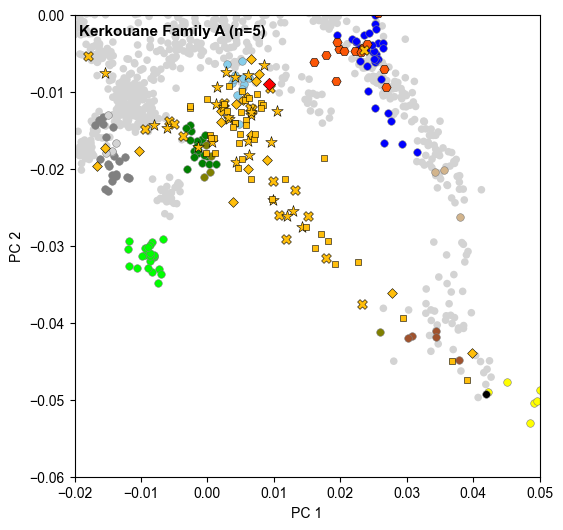

In [20]:
#iids_fam1 = ["I24040", "I24494", "I24193", "I24215", "I24194"]
iids_fam1 = ["I24194"]
idx1 = df["iid1"].isin(iids_fam1)
idx2 = df["iid2"].isin(iids_fam1)
dfk = df[idx1 & idx2] # Within Punic IBD

plot_family_ibd(df_ibd_fam=dfk, iids_fam=iids_fam1, 
                xlim=[-0.02,0.05], ylim=[-0.06,0.00],
                title="Kerkouane Family A (n=5)", savepath='')
#./figures/pca/fam_pca/kerk_famA.pdf

In [13]:
dfk

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,...,age1,age2,loc1,loc2,n_cov_snp1,n_cov_snp2,clst1,clst2,ls,lw
267,I24040,I24494,283.652203,3333.716194,20.0,3333.716194,20.0,3333.716194,20.0,3333.716194,...,2547.0,2464.0,Kerkouane,Kerkouane,860682,791516,Tunisia_Punic.SG,Tunisia_Punic_mother.or.daughter.I24040,-,2.0
989,I24494,I24193,283.652203,2005.149298,32.0,1985.909503,30.0,1958.025506,28.0,1922.099313,...,2464.0,2500.0,Kerkouane,Kerkouane,791516,789887,Tunisia_Punic_mother.or.daughter.I24040,Tunisia_Punic,--,2.0
2047,I24040,I24193,128.366596,1003.366010,32.0,946.618403,26.0,920.824103,24.0,830.916093,...,2547.0,2500.0,Kerkouane,Kerkouane,860682,789887,Tunisia_Punic.SG,Tunisia_Punic,-.,1.5
2611,I24194,I24494,75.874001,714.631484,16.0,696.773581,14.0,696.773581,14.0,679.805879,...,2500.0,2464.0,Kerkouane,Kerkouane,791265,791516,Tunisia_Punic,Tunisia_Punic_mother.or.daughter.I24040,-.,1.5
2561,I24194,I24193,77.237201,732.451471,22.0,713.814671,20.0,673.944468,17.0,657.024176,...,2500.0,2500.0,Kerkouane,Kerkouane,791265,789887,Tunisia_Punic,Tunisia_Punic,-.,1.5
3298,I24494,I24215,92.417502,477.516500,10.0,469.002405,9.0,469.002405,9.0,469.002405,...,2464.0,2505.0,Kerkouane,Kerkouane,791516,1085353,Tunisia_Punic_mother.or.daughter.I24040,Tunisia_Punic_oAfrica,:,1.5
4445,I24040,I24194,74.766899,296.729207,10.0,256.621492,6.0,256.621492,6.0,256.621492,...,2547.0,2500.0,Kerkouane,Kerkouane,860682,791265,Tunisia_Punic.SG,Tunisia_Punic,:,1.5
4274,I24193,I24215,90.698195,316.495398,14.0,284.886196,11.0,230.299905,7.0,194.081602,...,2500.0,2505.0,Kerkouane,Kerkouane,789887,1085353,Tunisia_Punic,Tunisia_Punic_oAfrica,:,1.5
5784,I24040,I24215,62.770103,205.133484,6.0,205.133484,6.0,205.133484,6.0,186.140393,...,2547.0,2505.0,Kerkouane,Kerkouane,860682,1085353,Tunisia_Punic.SG,Tunisia_Punic_oAfrica,:,1.5
9205,I24194,I24215,54.115105,120.898995,6.0,110.503897,5.0,54.115105,1.0,54.115105,...,2500.0,2505.0,Kerkouane,Kerkouane,791265,1085353,Tunisia_Punic,Tunisia_Punic_oAfrica,:,1.5


In [ ]:
df_p[df_p["iid"].str.contains("I24494|I24193")]

In [ ]:
dfkdf_p

# Plot Tharros Family

Saved to: ./figures/pca/fam_pca/tharros_fam.pdf


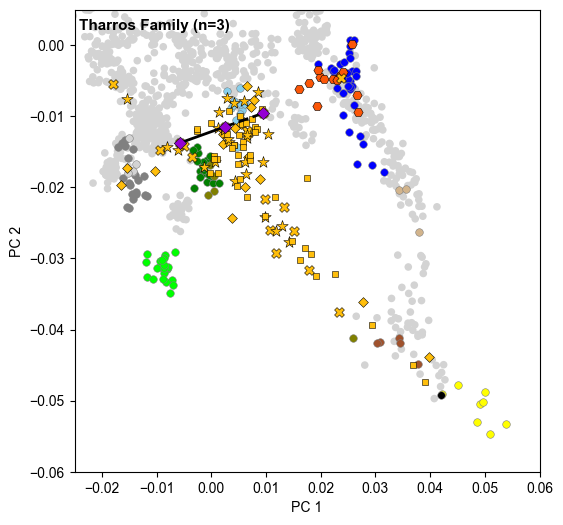

In [21]:
iids_tharr_fam = ["I22117", "I22118", "I22122"]

idx1 = dft2["iid1"].isin(iids_tharr_fam)
idx2 = dft2["iid2"].isin(iids_tharr_fam)
dft = dft2[idx1 & idx2] # Within Punic IBD

plot_family_ibd(df_ibd_fam=dft, iids_fam=iids_tharr_fam, 
                title="Tharros Family (n=3)", c_iid="darkviolet",
                savepath='./figures/pca/fam_pca/tharros_fam.pdf')

In [22]:
dft

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,...,age1,age2,loc1,loc2,n_cov_snp1,n_cov_snp2,clst1,clst2,ls,lw
426,I22122,I22118,213.983188,3310.906489,25.0,3310.906489,25.0,3310.906489,25.0,3276.589797,...,2419.0,2589.0,"Sardinia, Tharros","Sardinia, Tharros",711166,802359,Italy_Sardinia_Punic_Early,Italy_Sardinia_Punic_Early,-,2.0
1243,I22122,I22117,176.443803,1689.705997,23.0,1689.705997,23.0,1689.705997,23.0,1689.705997,...,2419.0,2582.0,"Sardinia, Tharros","Sardinia, Tharros",711166,791179,Italy_Sardinia_Punic_Early,Italy_Sardinia_Punic_Early,--,2.0


### Plot both in one figure

Saved to: ./figures/pca/fam_pca/pca_2fams.ker.tharros.pdf


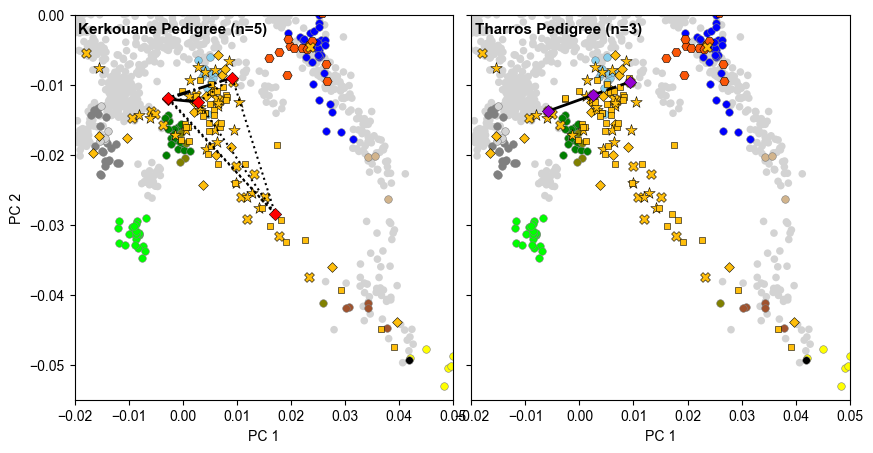

In [28]:
figsize=(10,5)

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.05, figure=fig)

# Do the left bar
ax0 = plt.subplot(gs[0]) 
ax1 = plt.subplot(gs[1]) 

plot_family_ibd(df_ibd_fam=dfk, iids_fam=iids_fam1, ax=ax0,
                xlim=[-0.02,0.05], ylim=[-0.055,0.00],
                title="Kerkouane Pedigree (n=5)", savepath='', show=False)

plot_family_ibd(df_ibd_fam=dft, iids_fam=iids_tharr_fam, ax=ax1,
                xlim=[-0.02,0.05], ylim=[-0.055,0.00],
                title="Tharros Pedigree (n=3)", c_iid="darkviolet",
                savepath="", show=False)

ax1.set_yticklabels([])
ax1.set_ylabel("")

savepath="./figures/pca/fam_pca/pca_2fams.ker.tharros.pdf"
plt.savefig(savepath, bbox_inches = 'tight', 
            pad_inches = 0, dpi=600)
print(f"Saved to: {savepath}")

plt.show()

In [20]:
dfk

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20,age1,age2,loc1,loc2,n_cov_snp1,n_cov_snp2,clst1,clst2
426,I22122,I22118,213.983188,3310.906489,25.0,3310.906489,25.0,3310.906489,25.0,3276.589797,23.0,2419.0,2589.0,"Sardinia, Tharros","Sardinia, Tharros",711166,802359,Italy_Sardinia_Punic_Early,Italy_Sardinia_Punic_Early
1243,I22122,I22117,176.443803,1689.705997,23.0,1689.705997,23.0,1689.705997,23.0,1689.705997,23.0,2419.0,2582.0,"Sardinia, Tharros","Sardinia, Tharros",711166,791179,Italy_Sardinia_Punic_Early,Italy_Sardinia_Punic_Early


Saved to: ./figures/pca/fam_pca/kerk_famB.pdf


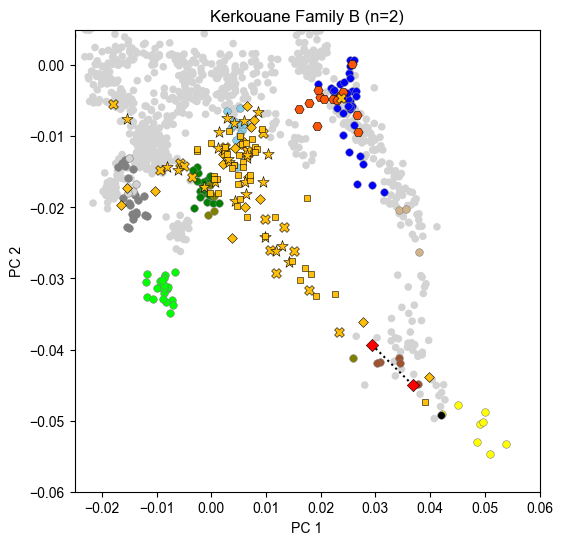

In [72]:
iids_kerk_fam = ["I24206", "I24205"]

idx1 = df["iid1"].isin(iids_kerk_fam)
idx2 = df["iid2"].isin(iids_kerk_fam)
dfk = df[idx1 & idx2] # Within Punic IBD

plot_family_ibd(df_ibd_fam=dfk, iids_fam=iids_kerk_fam, title="Kerkouane Family B (n=2)", savepath='./figures/pca/fam_pca/kerk_famB.pdf')

In [73]:
dfk

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,...,age1,age2,loc1,loc2,n_cov_snp1,n_cov_snp2,clst1,clst2,ls,lw
7880,I24206,I24205,43.115699,142.49661,6.0,121.943808,4.0,107.427704,3.0,107.427704,...,2434.0,2442.0,Kerkouane,Kerkouane,799375,846660,Tunisia_Punic_oAfricaHigh,Tunisia_Punic_oAfricaHigh,:,1.5


# Villaricos Family

Saved to: ./figures/pca/fam_pca/vill_fam.pdf


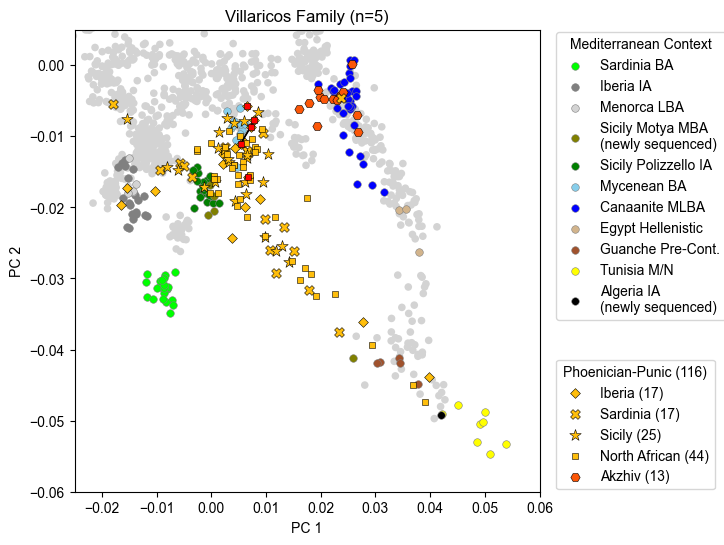

In [197]:
iids_kerk_fam = ["I18199", "I18200", "I18201", "I18202", "I18203"]

idx1 = df["iid1"].isin(iids_kerk_fam)
idx2 = df["iid2"].isin(iids_kerk_fam)
dfk = df[idx1 & idx2] # Within Punic IBD

plot_family_ibd(df_ibd_fam=dfk, iids_fam=iids_kerk_fam, title="Villaricos Family (n=5)", savepath='./figures/pca/fam_pca/vill_fam.pdf')

# Plot Distant IBD relatives

In [16]:
dft_all16=dft_all[dft_all["n_IBD>16"]==1]

In [ ]:
clsts_it_ia = "Italy_IA|Italy_LIA|Italy_MIA|Italy_Sicily_IA_Polizzello|Italy_Campania_IA|Italy_EIA|Italy_South_IA_Sanniti"
idx1= dft_all16["clst1"].str.contains(clsts_it_ia)
idx2 = dft_all16["clst2"].str.contains(clsts_it_ia)
idx = idx1 | idx2
print(f"{np.sum(idx)} / {len(idx)} pairs involving Italy/Sicily IA")
dft_all16[~idx]

### Almost no within Punic sample IBD

In [ ]:
df16p=dft[dft["n_IBD>16"]==1]
print(len(df16p))
df16p

### Plot all IBD Paris with 2 IBD

In [ ]:
savepath=""

for _, row in dft2[:].iterrows():
    iid1=row["iid1"]
    iid2=row["iid2"]
    sum_ibd=row["sum_IBD>12"]

    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    ### Plot Context
    lw=0.4
    ec="gray"
    s=30
    
    plot_pca_ho(ax, df_ho, c="lightgray", text=False)
    l1 = plot_pca(ax, df_is, c="blue", legend="", ec=ec, s=s, lw=lw)
    l2 = plot_pca(ax, df_greek, c="skyblue", legend="", ec=ec, s=s, lw=lw)
    l3 = plot_pca(ax, df_spain, c="gray", legend="", s=s, ec=ec, lw=lw)
    l4 = plot_pca(ax, df_sard_ba, c="lime", legend="", ec=ec, s=s, lw=lw)
    l5 = plot_pca(ax, df_sic_ia, c="green", legend="", s=s, ec=ec, lw=lw)
    l6 = plot_pca(ax, df_sic_mba, c="olive", legend="", s=s, ec=ec, lw=lw)
    l7 = plot_pca(ax, df_tun, c="yellow", legend="", ec=ec, s=s, lw=lw)
    l8 = plot_pca(ax, df_gua, c="sienna", legend="", s=s, ec=ec, lw=lw)
    l9 = plot_pca(ax, df_meno, c="lightgray", legend="", s=s, ec=ec, lw=lw)
    l10 = plot_pca(ax, df_eg_hell, c="tan", legend="", s=s, ec=ec, lw=lw)
    l11 = plot_pca(ax, df_alg_ia, c="k", legend="", s=s, ec=ec, lw=lw)
    #l12 = plot_pca(ax, df_turk, c="violet", legend="", s=s, ec=ec, lw=lw)
    
    labels = ["Sardinia BA", "Iberia IA", "Menorca LBA", "Sicily Motya MBA\n(newly sequenced)", "Sicily Polizzello IA", 
              "Mycenean BA", "Canaanite MLBA", "Egypt Hellenistic", "Guanche Pre-Cont.",
              "Tunisia M/N", "Algeria IA\n(newly sequenced)"]
    # "Turkey Hellenistic"
    
    ### Plot the Phoenician-Punic Samples
    s=25
    lw=0.4
    ec="k"
    alpha=1.0
    c_ph = "#fb5607"
    c_p = "#ffbe0b"
    m_ar = "H"
    m_sic = "*"
    m_ib = "D"
    m_naf = "s" 
    m_sar = "X"
    
    ### Plot Akzhiv Phoenicians
    a1 = plot_pca(ax, df_isp, c=c_ph, 
             legend="", ec=ec, alpha=alpha, s=s*1.8, marker=m_ar, lw=lw)
    
    ### Plot Punic Mediterranean
    a2 = plot_pca(ax, df_pp_ib, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s, marker=m_ib, lw=lw)
    
    a3 = plot_pca(ax, df_pp_sar, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s*2, marker=m_sar, lw=lw)
    
    a4 = plot_pca(ax, df_pp_sic, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s*3, marker=m_sic, lw=lw)
    
    a5 = plot_pca(ax, df_p_nafr, c=c_p, 
             legend="", ec=ec, alpha=alpha, s=s, marker=m_naf, lw=lw)
    
    ### Plot Connection
    plot_pair_ibd(ax, iid1=iid1, iid2=iid2, df=df_p, lw=2)
    
    ### Legends
    plots = [l4, l3, l9, l6, l5, l2, l1, l10, l8, l7, l11]
    leg1 = ax.legend(plots, labels, fontsize=10, 
              bbox_to_anchor=(1.02,1.01), loc="upper left")
    leg1.set_title(title = "Mediterranean Context")
    
    plots = [a2, a3, a4, a5, a1]
    legs = [f"Iberia ({len(df_pp_ib)})", 
            f"Sardinia ({len(df_pp_sar)})", 
            f"Sicily ({len(df_pp_sic)})",
            f"North African ({len(df_p_nafr)})", 
            f"Akzhiv ({len(df_isp)})"
           ]
    n = len(df_pp_ib) + len(df_pp_sar) + len(df_pp_sic) + len(df_p_nafr) + len(df_isp)
    
    leg = ax.legend(plots, legs, fontsize=10, bbox_to_anchor=(1.02, -0.01),
              loc="lower left", title=f"Phoenician-Punic ({n})")
    
    ax.add_artist(leg1)
    
    ### Title left top:
    ax.text(0.98, 0.98, "", weight='bold',
            ha="right", va="top", fontsize=12, transform = ax.transAxes, zorder=20)
    
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_xlim([-0.025,0.06])
    ax.set_ylim([-0.06,0.005])
    
    #ax.set_xlim([-0.02,0.03])
    #ax.set_ylim([-0.02,0.00])
    
    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=600)
        print(f"Saved to: {savepath}")
    
    ax.set_title(f"{iid1} - {iid2} ({sum_ibd:.1f}cm summed IBD>12cm")
    plt.show()